## Crawling topuniversities.com

Running this code takes time, as ~1000 webpages need to be requested and parsed. The code was run only once, and the DataFrame was saved with pickle. Some postprocessing (renaming columns, etc) had to be done afterwards to minimize internet traffic.

In [69]:
# Import libraries
import requests
from bs4 import BeautifulSoup
import json
import numpy as np
import pandas as pd
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## Later we will have a DataFrame where each cell has some html code in it from which
## we have to extract the necessary values. This function helps to run Beautifulsoup on
## each column at once instead of running it on each cells separately. The function
## helps to create a single string out of the column
def addS(x,y):
    if type(y) is str:
        return x+y + "\n"
    else:
        return x

We begin by requesting the data in the table of the "Ranking indicators" on https://www.topuniversities.com/university-rankings/world-university-rankings/2018 The table is actually populated using a json object that has the appropriate html code as cells.


In [3]:
URL = 'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051_indicators.txt'
r = requests.get(URL)
page_body = r.text
jdata=json.loads(page_body)

Now we import the json object into pandas and extract the necessary information from each column using Beautfulsoup. For better performance we don't call Beautfulsoup on each cell, but rather transform each column into one string and call Beautfulsoup on that. For most of the cells the info is in the div with class=td-wrap-in, except the univerity name and link which had to be handled separately. 

In [20]:
PDdata=pd.DataFrame(jdata["data"])
PDdata=PDdata.loc[0:199] # we only need the top 200 unis

soup=BeautifulSoup(reduce(addS, PDdata["uni"].values), 'html.parser')
wrappers= soup.find_all('a')
PDdata["uni"]=[p.text for p in wrappers]
PDdata["link"]=[p['href'] for p in wrappers]

codes=["2971069","2971070","2971071","2971072","2971073","2971074"] # rest of the data 
for code in codes:
    soup=BeautifulSoup(reduce(addS, PDdata[code].values), 'html.parser')
    wrappers= soup.find_all('div',class_="td-wrap-in")
    PDdata[code][[not x for x in PDdata[code].isnull().values]]=[float(p.text) for p in wrappers]


## dropping unnecessary stuff, renaming columns 
drop_codes=["","2971069_rank_d","2971070_rank_d","2971071_rank_d","2971072_rank_d","2971073_rank_d","2971074_rank_d","_rank_d","overall","overall_rank_dis"]
PDdata=PDdata.drop(drop_codes,axis=1)
PDdata.columns=["academic reputation score",
                "citations per faculty score",
                "employer reputation score",
                "faculty-student score",
                "international faculty score",
                "international students score",
                "country",
                "overall rank",
                "region",
                "stars",
                "name",
                "link"]


## For some reason the type of these columns had to be set manually
PDdata["academic reputation score"]=PDdata["academic reputation score"].astype(float)
PDdata["citations per faculty score"]=PDdata["citations per faculty score"].astype(float)
PDdata["employer reputation score"]=PDdata["employer reputation score"].astype(float)
PDdata["faculty-student score"]=PDdata["faculty-student score"].astype(float)
PDdata["international students score"]=PDdata["international students score"].astype(float)
PDdata["international faculty score"]=PDdata["international faculty score"].astype(float)
PDdata["overall rank"]=PDdata["overall rank"].astype(int)


PDdata.dtypes

academic reputation score       float64
citations per faculty score     float64
employer reputation score       float64
faculty-student score           float64
international faculty score     float64
international students score    float64
country                          object
overall rank                      int64
region                           object
stars                            object
name                             object
link                             object
dtype: object

Since the info on the (international) students/faculty is not available here we need to visit the page dedicated to each university separately. This is the part of the code that takes a considerable amount of time. Note that the details page of NYU (index 51) doesn't have the necessary info. For index 189, we are missing only one entry, this we will fill separately.

In [50]:
url_data=np.full((PDdata.shape[0],4),np.nan)
for i in range(PDdata.shape[0]):
    URL = 'https://www.topuniversities.com/'+ PDdata["link"][i]
    r = requests.get(URL)
    page_body = r.text
    page_body

    soup = BeautifulSoup(page_body, 'html.parser')
    all_links = soup.find_all('div', class_='number')
    temp_data=[int(p.text[1:-1].replace(",","")) for p in all_links]
    if len(temp_data)==8:
        url_data[i,:]=temp_data[0:4]
    else:
        print(i)

51
189


In [51]:
URL = 'https://www.topuniversities.com/'+ PDdata["link"][189]
r = requests.get(URL)
page_body = r.text
page_body

soup = BeautifulSoup(page_body, 'html.parser')
all_links = soup.find_all('div', class_='number')
temp_data=[int(p.text[1:-1].replace(",","")) for p in all_links]
url_data[189,0]=temp_data[0]
url_data[189,2]=temp_data[1]
url_data[189,3]=temp_data[2]


In [52]:
PDdata["total faculty"]=url_data[:,0]
PDdata["international faculty"]=url_data[:,1]
PDdata["total students"]=url_data[:,2]
PDdata["international studets"]=url_data[:,3]

We also need to compute some new feautres for later use

In [53]:
PDdata["student-faculty ratio"]=np.divide(PDdata["total faculty"],PDdata["total students"])
PDdata["international student ratio"]=np.divide(PDdata["international studets"],PDdata["total students"])
PDdata["international faculty ratio"]=np.divide(PDdata["international faculty"],PDdata["total faculty"])
PDdata

,academic reputation score,citations per faculty score,employer reputation score,faculty-student score,international faculty score,international students score,country,overall rank,region,stars,name,link,total faculty,international faculty,total students,international studets,student-faculty ratio,international student ratio,international faculty ratio
0,100.0,99.9,100.0,100.0,100.0,96.1,United States,1,North America,6,Massachusetts Institute of Technology (MIT),/universities/massachusetts-institute-technolo...,2982.0,1679.0,11067.0,3717.0,0.269450,0.335863,0.563045
1,100.0,99.4,100.0,100.0,99.6,72.7,United States,2,North America,5,Stanford University,/universities/stanford-university,4285.0,2042.0,15878.0,3611.0,0.269870,0.227422,0.476546
2,100.0,99.9,100.0,98.3,96.5,75.2,United States,3,North America,5,Harvard University,/universities/harvard-university,4350.0,1311.0,22429.0,5266.0,0.193945,0.234785,0.301379
3,99.5,100.0,85.4,100.0,93.4,89.2,United States,4,North America,5,California Institute of Technology (Caltech),/universities/california-institute-technology-...,953.0,350.0,2255.0,647.0,0.422616,0.286918,0.367261
4,100.0,78.3,100.0,100.0,97.4,97.7,United Kingdom,5,Europe,5,University of Cambridge,/universities/university-cambridge,5490.0,2278.0,18770.0,6699.0,0.292488,0.356899,0.414936
5,100.0,76.3,100.0,100.0,98.6,98.5,United Kingdom,6,Europe,5,University of Oxford,/universities/university-oxford,6750.0,2964.0,19720.0,7353.0,0.342292,0.372870,0.439111
6,99.7,74.7,99.5,99.1,96.6,100.0,United Kingdom,7,Europe,None,UCL (University College London),/universities/ucl-university-college-london,6345.0,2554.0,31080.0,14854.0,0.204151,0.477928,0.402522
7,99.4,68.7,100.0,100.0,100.0,100.0,United Kingdom,8,Europe,None,Imperial College London,/universities/imperial-college-london,3930.0,2071.0,16090.0,8746.0,0.244251,0.543567,0.526972
8,99.9,85.9,92.9,96.5,71.9,79.8,United States,9,North America,5,University of Chicago,/universities/university-chicago,2449.0,635.0,13557.0,3379.0,0.180645,0.249244,0.259290
9,99.6,98.7,99.4,68.2,100.0,98.8,Switzerland,10,Europe,None,ETH Zurich - Swiss Federal Institute of Techno...,/universities/eth-zurich-swiss-federal-institu...,2477.0,1886.0,19815.0,7563.0,0.125006,0.381681,0.761405


Now we save the dataframe so we don't have to rerun the code.

In [55]:
PDdata.to_pickle("topuniversities.p")

In [56]:
PDdata=pd.read_pickle("topuniversities.p")

Now we will calculate the best countries in terms of student to staff ratio (highest considered best) and also in terms of percentage of international students (highest considered best):

In [57]:
PDdata.sort_values(ascending=[False], by=['student-faculty ratio'])[['name','overall rank','student-faculty ratio']].head(20)

,name,overall rank,student-faculty ratio
3,California Institute of Technology (Caltech),4,0.422616
15,Yale University,16,0.398323
5,University of Oxford,6,0.342292
4,University of Cambridge,5,0.292488
16,Johns Hopkins University,17,0.276353
1,Stanford University,2,0.269870
0,Massachusetts Institute of Technology (MIT),1,0.269450
185,University of Rochester,186,0.266604
18,University of Pennsylvania,19,0.266437
17,Columbia University,18,0.247115


In [58]:
PDdata.sort_values(ascending=[False], by=['international student ratio'])[['name','overall rank','international student ratio']].head(20)

,name,overall rank,international student ratio
34,London School of Economics and Political Scien...,35,0.691393
11,Ecole Polytechnique Fédérale de Lausanne (EPFL),12,0.570047
7,Imperial College London,8,0.543567
199,Maastricht University,200,0.502533
46,Carnegie Mellon University,47,0.478062
6,UCL (University College London),7,0.477928
91,University of St Andrews,92,0.457955
41,The University of Melbourne,41,0.427434
126,Queen Mary University of London,127,0.421816
25,The University of Hong Kong,26,0.407144


In [59]:
PDdata.sort_values(ascending=[False], by=['international faculty ratio'])[['name','overall rank','international faculty ratio']].head(20)

,name,overall rank,international faculty ratio
11,Ecole Polytechnique Fédérale de Lausanne (EPFL),12,0.766962
9,ETH Zurich - Swiss Federal Institute of Techno...,10,0.761405
48,City University of Hong Kong,49,0.761305
29,The Hong Kong University of Science and Techno...,30,0.726087
25,The University of Hong Kong,26,0.692231
10,"Nanyang Technological University, Singapore (NTU)",11,0.689949
149,University of Basel,149,0.647114
34,London School of Economics and Political Scien...,35,0.631434
172,King Fahd University of Petroleum & Minerals,173,0.626177
14,National University of Singapore (NUS),15,0.604387


Now we want similar stats aggregated on country/region. As you can see below, UAE has the highest ratio of international students, with more than 50% of students being international.

In [60]:
PDdata.columns

Index(['academic reputation score', 'citations per faculty score',
       'employer reputation score', 'faculty-student score',
       'international faculty score', 'international students score',
       'country', 'overall rank', 'region', 'stars', 'name', 'link',
       'total faculty', 'international faculty', 'total students',
       'international studets', 'student-faculty ratio',
       'international student ratio', 'international faculty ratio'],
      dtype='object')

In [64]:
ranking_extended_1 = PDdata.copy()

cols_list = ['name', 'total faculty', 'international studets', 'total students']

def do_country_region_agg(df, col_name, columns_list):
    columns_list.append(col_name)
    df_agg = df[columns_list]
    df_agg = df_agg.groupby(col_name).sum()
    df_agg['international student ratio'] = df_agg['international studets']/df_agg['total students']
    df_agg['student-faculty ratio'] = df_agg['total faculty']/df_agg['total students']
    return df_agg

ranking_aggregated_country = do_country_region_agg(ranking_extended_1, 'country', cols_list)
ranking_aggregated_country.sort_values(ascending=False, by='international student ratio').head(20)

,total faculty,international studets,total students,international student ratio,student-faculty ratio
country,,,,,
Australia,22034.0,106359.0,301994.0,0.352189,0.072962
United Kingdom,79934.0,199426.0,583621.0,0.341705,0.136962
Hong Kong,10166.0,24499.0,78838.0,0.310751,0.128948
Austria,4117.0,19667.0,63446.0,0.309980,0.064890
Switzerland,15323.0,32995.0,109112.0,0.302396,0.140434
Singapore,9444.0,16168.0,58466.0,0.276537,0.161530
Canada,29317.0,73239.0,281514.0,0.260161,0.104140
New Zealand,3313.0,12439.0,48173.0,0.258215,0.068773
Ireland,2853.0,8187.0,34794.0,0.235299,0.081997


In [65]:
ranking_aggregated_country.sort_values(ascending=False, by='student-faculty ratio').head(20)

,total faculty,international studets,total students,international student ratio,student-faculty ratio
country,,,,,
Russia,6709.0,5098.0,30233.0,0.168624,0.221910
Denmark,11916.0,9543.0,67223.0,0.141960,0.177261
Saudi Arabia,1062.0,989.0,6040.0,0.163742,0.175828
Singapore,9444.0,16168.0,58466.0,0.276537,0.161530
Malaysia,2755.0,3476.0,17902.0,0.194168,0.153893
Japan,28395.0,16269.0,186222.0,0.087363,0.152479
South Korea,19851.0,16273.0,140071.0,0.116177,0.141721
Switzerland,15323.0,32995.0,109112.0,0.302396,0.140434
United Kingdom,79934.0,199426.0,583621.0,0.341705,0.136962


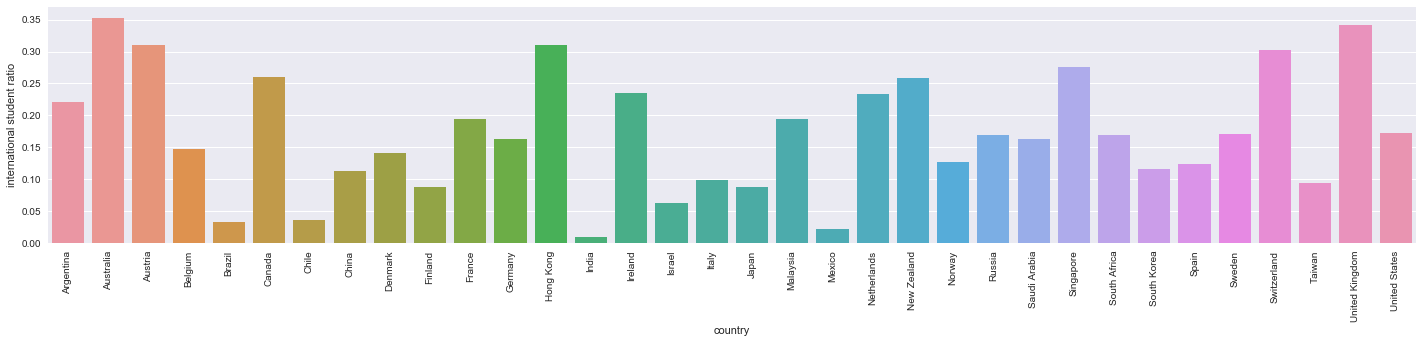

In [70]:
ax = sns.factorplot(kind = 'bar', x="country", y="international student ratio", data=ranking_aggregated_country.reset_index(), aspect=5)
plt.xticks(rotation=90)
plt.show(ax)

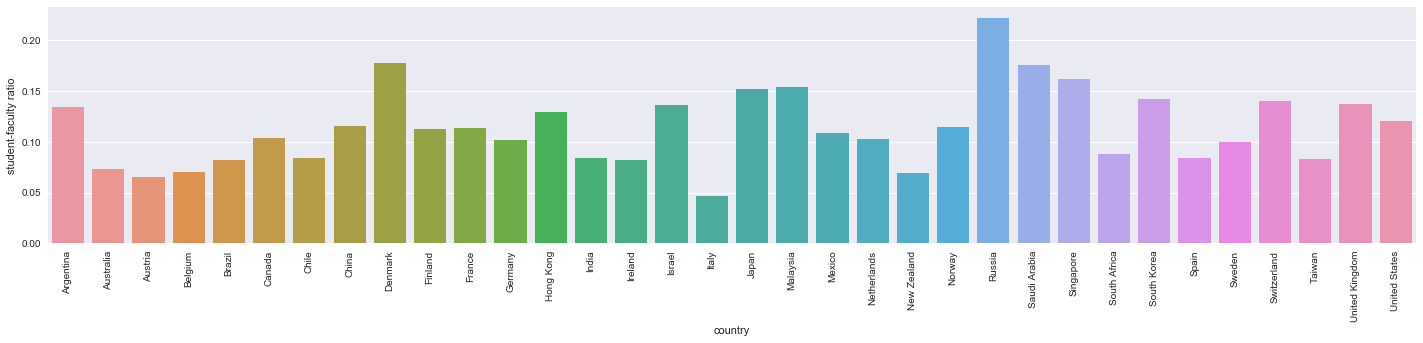

In [72]:
ax = sns.factorplot(kind = 'bar', x="country", y="student-faculty ratio", data=ranking_aggregated_country.reset_index(), aspect=5)
plt.xticks(rotation=90)
plt.show(ax)

In [73]:
ranking_aggregated_region = do_country_region_agg(ranking_extended_1, 'region', cols_list)
ranking_aggregated_region.sort_values(ascending=False, by='international student ratio').head(20)

,total faculty,international studets,total students,international student ratio,student-faculty ratio
region,,,,,
Oceania,25347.0,118798.0,350167.0,0.339261,0.072385
Europe,223271.0,454293.0,1991280.0,0.228141,0.112124
North America,182123.0,292116.0,1546353.0,0.188906,0.117776
Africa,1733.0,3325.0,19593.0,0.169703,0.088450
Asia,106734.0,110100.0,807003.0,0.136431,0.132260
Latin America,43126.0,34737.0,396902.0,0.087520,0.108657


In [74]:
ranking_aggregated_region.sort_values(ascending=False, by='student-faculty ratio').head(20)

,total faculty,international studets,total students,international student ratio,student-faculty ratio
region,,,,,
Asia,106734.0,110100.0,807003.0,0.136431,0.132260
North America,182123.0,292116.0,1546353.0,0.188906,0.117776
Europe,223271.0,454293.0,1991280.0,0.228141,0.112124
Latin America,43126.0,34737.0,396902.0,0.087520,0.108657
Africa,1733.0,3325.0,19593.0,0.169703,0.088450
Oceania,25347.0,118798.0,350167.0,0.339261,0.072385


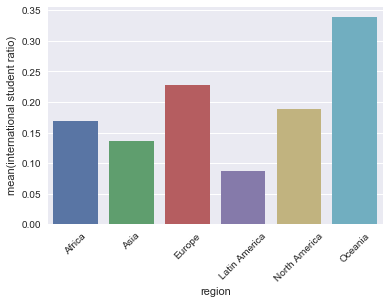

In [75]:
ax = sns.barplot(x="region", y="international student ratio", data=ranking_aggregated_region.reset_index())
plt.xticks(rotation=45)
plt.show(ax)

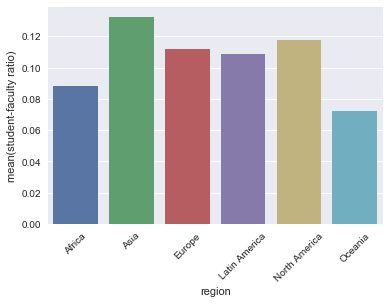

In [76]:
ax = sns.barplot(x="region", y="student-faculty ratio", data=ranking_aggregated_region.reset_index())
plt.xticks(rotation=45)
plt.show(ax)